In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from datetime import date
import seaborn as sns
from pygam import LinearGAM
from pygam.utils import generate_X_grid

### Create regression data

In [2]:
tfidf_path = '../../data/tfidf_toprev_conlen_fulldata/'

In [3]:
lda_path = '../../data/lda_jsd_toprev_conlen/'

In [4]:
tag_path = '../../data/tag_novelty_full/'

In [5]:
fandom_list = ['harry_potter',
 'dcu',
 'doctor_who_&_related_fandoms',
 'star_wars_all_media_types',
 'arthurian_mythology_&_related_fandoms',
 'supernatural',
 'haikyuu',
 'kuroko_no_basuke',
 'hamilton_miranda',
 'dragon_age_all_media_types',
 'the_walking_dead_&_related_fandoms',
 'buffy_the_vampire_slayer',
 'les_miserables_all_media_types',
 'naruto',
 'tolkien_j_r_r_works_&_related_fandoms',
 'shakespare_william_works',
 'hetalia_axis_powers',
 'attack_on_titan',
 'ms_paint_adventures',
 'homestuck',
 'marvel',
 'bishoujo_senshi_sailor_moon',
 'one_direction',
 'sherlock_holmes_&_related_fandoms']

In [228]:
df_all = []
for i,fandom in enumerate(fandom_list):
    df_tfidf = pd.read_csv(os.path.join(tfidf_path,fandom + '_temporal_tfidf_cos_toprev_conlen.tsv'), sep = '\t')
    del df_tfidf['index']
    df_lda = pd.read_csv(os.path.join(lda_path,fandom + '_temporal_lda_jsd_toprev_full.tsv'), sep = '\t')
    del df_lda['index']
    df_tag = pd.read_csv(os.path.join(tag_path,fandom + '_tag_novelty_conlen_full.tsv'), sep = '\t')
    df = pd.merge(df_tfidf, df_lda, on=['AdditionalTags', 'ArchiveWarnings', 'Author', 'Bookmarks', 'Category',\
 'ChapterIndex', 'Chapters' ,'Characters','Comments' ,'CompleteDate',\
 'Fandoms', 'Hits' ,'Kudos', 'Language', 'Notes' ,'PublishDate' ,'Rating',\
 'Relationship' ,'Summary' ,'Title' ,'URL' ,'UpdateDate' ,'Words'], how='inner')
    df = pd.merge(df, df_tag, on=['AdditionalTags', 'ArchiveWarnings', 'Author', 'Bookmarks', 'Category',\
 'ChapterIndex', 'Chapters' ,'Characters','Comments' ,'CompleteDate',\
 'Fandoms', 'Hits' ,'Kudos', 'Language', 'Notes' ,'PublishDate' ,'Rating',\
 'Relationship' ,'Summary' ,'Title' ,'URL' ,'UpdateDate' ,'Words'], how='inner')
    
    df['fandom_category'] = fandom
    df['tag_novelty'] = df['tag_novelty'] * 100
    
    df['Kudos'] = df['Kudos']/df['Chapters']
#     df['Kudos'] = np.log(df['Kudos'])
    df['Hits'] = df['Hits']/df['Chapters']
#     df['Hits'] = np.log(df['Hits'])
#     df['Comments'] = np.log(df['Comments'])
    df['Bookmarks'] = df['Bookmarks']/df['Chapters']
#     df['Bookmarks'] = np.log(df['Bookmarks'])

#     df = df.dropna(subset=['Kudos'])
#     df = df[np.isfinite(df['Kudos'])]
#     df['Kudos'] = (df['Kudos'] - df['Kudos'].mean())/df['Kudos'].std(ddof=0)

    df_all.append(df)

In [229]:
df_all = pd.concat(df_all)

In [230]:
# df_all = df.head(500)

In [231]:
del df_all['Language']
del df_all['Notes']
del df_all['Summary']
del df_all['Title']
del df_all['URL']
del df_all['AdditionalTags']
del df_all['Fandoms']
del df_all['Characters']
del df_all['Words']

In [232]:
df_all['Category'].fillna('None', inplace=True)
df_all['Category_F_F'] = df_all['Category'].apply(lambda x: 1 if 'F/F' in x else 0)
df_all['Category_F_M'] = df_all['Category'].apply(lambda x: 1 if 'F/M' in x else 0)
df_all['Category_Gen'] = df_all['Category'].apply(lambda x: 1 if 'Gen' in x else 0)
df_all['Category_M_M'] = df_all['Category'].apply(lambda x: 1 if 'M/M' in x else 0)
df_all['Category_Multi'] = df_all['Category'].apply(lambda x: 1 if 'Multi' in x else 0)
df_all['Category_Other'] = df_all['Category'].apply(lambda x: 1 if 'Other' in x else 0)
df_all['Category_None'] = df_all['Category'].apply(lambda x: 1 if 'None' in x else 0)
del df_all['Category']

In [233]:
df_all['ArchiveWarnings_none'] = df_all['ArchiveWarnings'].apply(lambda x: 1 if 'None. - Warning' in x else 0)
df_all['ArchiveWarnings_underage'] = df_all['ArchiveWarnings'].apply(lambda x: 1 if 'Underage' in x else 0)
df_all['ArchiveWarnings_death'] = df_all['ArchiveWarnings'].apply(lambda x: 1 if 'Major Character Death' in x else 0)
df_all['ArchiveWarnings_choose_no'] = df_all['ArchiveWarnings'].apply(lambda x: 1 if 'Creator Chose Not To Use Archive Warnings' in x else 0)
df_all['ArchiveWarnings_no_apply'] = df_all['ArchiveWarnings'].apply(lambda x: 1 if 'No Archive Warnings Apply' in x else 0)
df_all['ArchiveWarnings_blood'] = df_all['ArchiveWarnings'].apply(lambda x: 1 if 'Blood - Warning' in x else 0)
df_all['ArchiveWarnings_violence'] = df_all['ArchiveWarnings'].apply(lambda x: 1 if 'Graphic Depictions Of Violence' in x else 0)
df_all['ArchiveWarnings_noncon'] = df_all['ArchiveWarnings'].apply(lambda x: 1 if 'Rape/Non-Con' in x else 0)

del df_all['ArchiveWarnings']

In [234]:
df_all['ChapterIndex'].fillna(0, inplace=True)

In [235]:
def first_relationship(field):
    try:
        return field.split(',')[0]
    except:
        return field

In [236]:
df_all['Relationship'] = df_all.apply(lambda row: first_relationship(row['Relationship']), axis=1)

In [237]:
counts = df_all['Author'].value_counts()
idx = counts[counts >= 10].index
df_all['Freq_author'] = df_all['Author'].apply(lambda x: 1 if x in(idx) else 0)
del df_all['Author']

In [238]:
set(df['Rating'].tolist())

{'Explicit',
 'General Audiences',
 'Mature',
 'Not Rated',
 'Teen And Up Audiences'}

In [239]:
df_all['Rating_E'] = df_all['Rating'].apply(lambda x: 1 if x == 'Explicit' else 0)
df_all['Rating_G'] = df_all['Rating'].apply(lambda x: 1 if x == 'General Audiences' else 0)
df_all['Rating_M'] = df_all['Rating'].apply(lambda x: 1 if x == 'Mature' else 0)
df_all['Rating_N'] = df_all['Rating'].apply(lambda x: 1 if x == 'Not Rated' else 0)
df_all['Rating_T'] = df_all['Rating'].apply(lambda x: 1 if x == 'Teen And Up Audiences' else 0)
del df_all['Rating']

In [240]:
counts = df_all['Relationship'].value_counts()
idx = counts[counts >= 10].index
df_all['Freq_relationship'] = df_all['Relationship'].apply(lambda x: 1 if x in(idx) else 0)
del df_all['Relationship']

In [241]:
df_all['Fandom_harry_potter'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'harry_potter' else 0)
df_all['Fandom_dcu'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'doctor_who_&_related_fandoms' else 0)
df_all['Fandom_doctor_who'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'doctor_who_&_related_fandoms' else 0)
df_all['Fandom_star_wars'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'star_wars_all_media_types' else 0)
df_all['Fandom_arthurian'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'arthurian_mythology_&_related_fandoms' else 0)
df_all['Fandom_supernatural'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'supernatural' else 0)
df_all['Fandom_haikyuu'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'haikyuu' else 0)
df_all['Fandom_kuroko_no_basuke'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'kuroko_no_basuke' else 0)
df_all['Fandom_hamilton_miranda'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'hamilton_miranda' else 0)
df_all['Fandom_dragon_age'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'dragon_age_all_media_types' else 0)
df_all['Fandom_the_walking_dead'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'the_walking_dead_&_related_fandoms' else 0)
df_all['Fandom_buffy'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'buffy_the_vampire_slayer' else 0)
df_all['Fandom_les_miserables'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'les_miserables_all_media_types' else 0)
df_all['Fandom_naruto'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'naruto' else 0)
df_all['Fandom_tolkien'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'tolkien_j_r_r_works_&_related_fandoms' else 0)
df_all['Fandom_shakespare'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'shakespare_william_works' else 0)
df_all['Fandom_hetalia'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'hetalia_axis_powers' else 0)
df_all['Fandom_attack_on_titan'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'attack_on_titan' else 0)
df_all['Fandom_ms_paint_adventures'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'ms_paint_adventures' else 0)
df_all['Fandom_homestuck'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'homestuck' else 0)
df_all['Fandom_marvel'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'marvel' else 0)
df_all['Fandom_sailor_moon'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'bishoujo_senshi_sailor_moon' else 0)
df_all['Fandom_one_direction'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'one_direction' else 0)
df_all['Fandom_sherlock'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'sherlock_holmes_&_related_fandoms' else 0)

del df_all['fandom_category']

In [242]:
# df_all['fandom_category'] = df_all['fandom_category'].astype('category')
# df_all['Fandom_cat'] = df_all['fandom_category'].cat.codes
# del df_all['fandom_category']

In [243]:
def date_today(cell):
    try:
        y, m, d = cell.split('-')
        return abs(date.today() - date(int(y), int(m), int(d))).days
    except:
        return float('nan')

In [244]:
df_all['PublishDate'] = df_all.apply(lambda row: date_today(row['PublishDate']), axis = 1)
df_all['CompleteDate'] = df_all.apply(lambda row: date_today(row['CompleteDate']), axis = 1)
df_all['UpdateDate'] = df_all.apply(lambda row: date_today(row['UpdateDate']), axis = 1)

In [245]:
def find_history(field_list):
    field_list = [10000000 if np.isnan(x) else x for x in field_list]
    return np.amin(field_list)

In [246]:
df_all['history'] = df_all.apply(lambda row: find_history([row['PublishDate'], row['CompleteDate'], row['UpdateDate']]), axis=1)

In [247]:
del df_all['PublishDate']
del df_all['CompleteDate']
del df_all['UpdateDate']

In [248]:
df_all.columns.values

array(['Bookmarks', 'ChapterIndex', 'Chapters', 'Comments', 'Hits',
       'Kudos', 'Cos', 'JSD', 'tag_novelty', 'Category_F_F',
       'Category_F_M', 'Category_Gen', 'Category_M_M', 'Category_Multi',
       'Category_Other', 'Category_None', 'ArchiveWarnings_none',
       'ArchiveWarnings_underage', 'ArchiveWarnings_death',
       'ArchiveWarnings_choose_no', 'ArchiveWarnings_no_apply',
       'ArchiveWarnings_blood', 'ArchiveWarnings_violence',
       'ArchiveWarnings_noncon', 'Freq_author', 'Rating_E', 'Rating_G',
       'Rating_M', 'Rating_N', 'Rating_T', 'Freq_relationship',
       'Fandom_harry_potter', 'Fandom_dcu', 'Fandom_doctor_who',
       'Fandom_star_wars', 'Fandom_arthurian', 'Fandom_supernatural',
       'Fandom_haikyuu', 'Fandom_kuroko_no_basuke',
       'Fandom_hamilton_miranda', 'Fandom_dragon_age',
       'Fandom_the_walking_dead', 'Fandom_buffy', 'Fandom_les_miserables',
       'Fandom_naruto', 'Fandom_tolkien', 'Fandom_shakespare',
       'Fandom_hetalia', 'Fandom

In [249]:
df_all = df_all.rename(columns = {'history':'History', 'Cos': 'Term_novelty', 'JSD': 'Topic_novelty'})

In [250]:
df_all.head()

,Bookmarks,ChapterIndex,Chapters,Comments,Hits,Kudos,Term_novelty,Topic_novelty,tag_novelty,Category_F_F,...,Fandom_shakespare,Fandom_hetalia,Fandom_attack_on_titan,Fandom_ms_paint_adventures,Fandom_homestuck,Fandom_marvel,Fandom_sailor_moon,Fandom_one_direction,Fandom_sherlock,History
0,0.666667,1.0,3,0,106.666667,2.666667,0.778655,0.599456,-0.012112,0,...,0,0,0,0,0,0,0,0,0,5106.0
1,0.000000,0.0,1,1,1359.000000,19.000000,0.879855,0.625602,NaN,0,...,0,0,0,0,0,0,0,0,0,5565.0
2,0.000000,0.0,1,0,60.000000,NaN,0.332479,0.573035,NaN,0,...,0,0,0,0,0,0,0,0,0,5566.0
3,0.000000,0.0,1,0,495.000000,12.000000,0.795259,0.650978,-0.006056,0,...,0,0,0,0,0,0,0,0,0,5569.0
4,0.000000,0.0,1,3,737.000000,38.000000,0.934369,0.644082,-0.006921,0,...,0,0,0,0,0,0,0,0,0,5571.0


In [251]:
df_all.to_csv('fanfic_regression_data_curated.tsv', sep = '\t', index=False)

In [252]:
len(df_all)

576408

In [3]:
df_all = pd.read_csv('fanfic_regression_data_curated.tsv', sep = '\t')

### GAM

In [4]:
df_all = df_all.replace([np.inf, -np.inf], np.nan)
df_all = df_all.dropna(how = 'any')

In [7]:
df_all = df_all.sort_values(by = 'Kudos')[:-1]

In [79]:
# df_all = df_all.sample(1000)

In [9]:
df_all.columns.values

array(['Bookmarks', 'ChapterIndex', 'Chapters', 'Comments', 'Hits',
       'Kudos', 'Term_novelty', 'Topic_novelty', 'tag_novelty',
       'Category_F_F', 'Category_F_M', 'Category_Gen', 'Category_M_M',
       'Category_Multi', 'Category_Other', 'Category_None',
       'ArchiveWarnings_none', 'ArchiveWarnings_underage',
       'ArchiveWarnings_death', 'ArchiveWarnings_choose_no',
       'ArchiveWarnings_no_apply', 'ArchiveWarnings_blood',
       'ArchiveWarnings_violence', 'ArchiveWarnings_noncon',
       'Freq_author', 'Rating_E', 'Rating_G', 'Rating_M', 'Rating_N',
       'Rating_T', 'Freq_relationship', 'Fandom_harry_potter',
       'Fandom_dcu', 'Fandom_doctor_who', 'Fandom_star_wars',
       'Fandom_arthurian', 'Fandom_supernatural', 'Fandom_haikyuu',
       'Fandom_kuroko_no_basuke', 'Fandom_hamilton_miranda',
       'Fandom_dragon_age', 'Fandom_the_walking_dead', 'Fandom_buffy',
       'Fandom_les_miserables', 'Fandom_naruto', 'Fandom_tolkien',
       'Fandom_shakespare', 'Fando

In [10]:
X = df_all[['ChapterIndex', 'Chapters','Term_novelty', 'Topic_novelty',
       'Category_F_F', 'Category_F_M', 'Category_Gen', 'Category_M_M',
       'Category_Multi', 'Category_Other', 'Category_None',
       'ArchiveWarnings_none', 'ArchiveWarnings_underage',
       'ArchiveWarnings_death', 'ArchiveWarnings_choose_no',
       'ArchiveWarnings_no_apply', 'ArchiveWarnings_blood',
       'ArchiveWarnings_violence', 'ArchiveWarnings_noncon',
       'Freq_author', 'Rating_E', 'Rating_G', 'Rating_M', 'Rating_N',
       'Rating_T', 'Freq_relationship', 'Fandom_harry_potter',
       'Fandom_dcu', 'Fandom_doctor_who', 'Fandom_star_wars',
       'Fandom_arthurian', 'Fandom_supernatural', 'Fandom_haikyuu',
       'Fandom_kuroko_no_basuke', 'Fandom_hamilton_miranda',
       'Fandom_dragon_age', 'Fandom_the_walking_dead', 'Fandom_buffy',
       'Fandom_les_miserables', 'Fandom_naruto', 'Fandom_tolkien',
       'Fandom_shakespare', 'Fandom_hetalia', 'Fandom_attack_on_titan',
       'Fandom_ms_paint_adventures', 'Fandom_homestuck', 'Fandom_marvel',
       'Fandom_sailor_moon', 'Fandom_one_direction', 'Fandom_sherlock',
       'History']]

In [11]:
y = df_all[['Kudos']]

In [12]:
# kwargs = {'lam': np.linspace(300,305,5), 'n_splines': np.linspace(0,50,5)}
# gam = LinearGAM()
# gam.gridsearch(X, y,**kwargs)
# gam.summary()

In [13]:
gam = LinearGAM(n_splines=25, lam=301.25).fit(X, y)
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     97.5608
Link Function:                     IdentityLink Log Likelihood:                              -4564866.6146
Number of Samples:                       510986 AIC:                                          9129930.3508
                                                AICc:                                         9129930.3892
                                                GCV:                                             3025.0636
                                                Scale:                                            3024.024
                                                Pseudo R-Squared:                                   0.1627
Feature Function   Data Type      Num

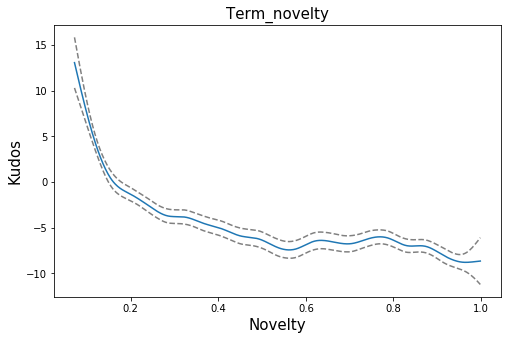

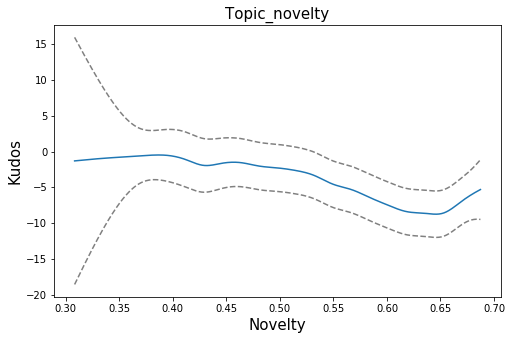

In [14]:
titles = ['ChapterIndex', 'Chapters','Term_novelty', 'Topic_novelty',
       'Category_F_F', 'Category_F_M', 'Category_Gen', 'Category_M_M',
       'Category_Multi', 'Category_Other', 'Category_None',
       'ArchiveWarnings_none', 'ArchiveWarnings_underage',
       'ArchiveWarnings_death', 'ArchiveWarnings_choose_no',
       'ArchiveWarnings_no_apply', 'ArchiveWarnings_blood',
       'ArchiveWarnings_violence', 'ArchiveWarnings_noncon',
       'Freq_author', 'Rating_E', 'Rating_G', 'Rating_M', 'Rating_N',
       'Rating_T', 'Freq_relationship', 'Fandom_harry_potter',
       'Fandom_dcu', 'Fandom_doctor_who', 'Fandom_star_wars',
       'Fandom_arthurian', 'Fandom_supernatural', 'Fandom_haikyuu',
       'Fandom_kuroko_no_basuke', 'Fandom_hamilton_miranda',
       'Fandom_dragon_age', 'Fandom_the_walking_dead', 'Fandom_buffy',
       'Fandom_les_miserables', 'Fandom_naruto', 'Fandom_tolkien',
       'Fandom_shakespare', 'Fandom_hetalia', 'Fandom_attack_on_titan',
       'Fandom_ms_paint_adventures', 'Fandom_homestuck', 'Fandom_marvel',
       'Fandom_sailor_moon', 'Fandom_one_direction', 'Fandom_sherlock',
       'History']

XX = generate_X_grid(gam)
for i in range(2,4):
    plt.figure(figsize = (8,5))
    pdep, confi = gam.partial_dependence(XX, feature=i+1, width=.95)
    plt.plot(XX[:, i], pdep)
    plt.plot(XX[:, i], confi[0][:, 0], c='grey', ls='--')
    plt.plot(XX[:, i], confi[0][:, 1], c='grey', ls='--')
    plt.title(titles[i],fontsize=15)
    plt.xlabel('Novelty', fontsize=15)
    plt.ylabel('Kudos',fontsize=15)